# Crash Course in Causality: Understanding Treatment Effect Heterogeneity in Education

## Abstract
This notebook explores the dataset derived from the National Study of Learning Mindsets, which evaluates the effectiveness of a "growth mindset" intervention on student achievement. The growth mindset intervention aims to instill the belief that intelligence can be developed. The dataset simulates a real-world observational study with similar characteristics to the original randomized controlled trial, allowing us to explore causal relationships and treatment heterogeneity.

We focus on estimating the **Average Treatment Effect (ATE)** and **Conditional Average Treatment Effect (CATE)** while identifying how individual and school-level covariates moderate the treatment effects. By the end of this notebook, readers will understand how data preparation and causal analysis can help derive actionable insights for educational interventions.

---

## Dataset Description

### Source
The dataset emulates data from the **National Study of Learning Mindsets**. It consists of approximately **10,000 students** in **76 schools** with the following columns:

| Column   | Description                                                                                                                                 |
|----------|---------------------------------------------------------------------------------------------------------------------------------------------|
| `schoolid` | Unique identifier for schools.                                                                                                             |
| `Z`       | **Binary treatment variable**: 1 indicates the intervention was received, 0 indicates control.                                              |
| `Y`       | **Outcome variable**: A continuous measure of student achievement.                                                                          |
| `S3`      | Students' self-reported expectations for success, a proxy for prior achievement (ordinal scale).                                            |
| `C1`      | **Categorical**: Student race/ethnicity.                                                                                                    |
| `C2`      | **Binary categorical**: Student identified gender.                                                                                          |
| `C3`      | **Binary categorical**: First-generation college student status (1 = first-generation, 0 = not first-generation).                          |
| `XC`      | School urbanicity (categorical: rural, suburban, etc.).                                                                                     |
| `X1`      | School-level mean of students' fixed mindsets, reported before the intervention.                                                            |
| `X2`      | School achievement level, measured by test scores and college preparation metrics.                                                          |
| `X3`      | School racial/ethnic minority composition (% Black, Latino, or Native American).                                                            |
| `X4`      | School poverty concentration (% of students from families below the federal poverty line).                                                  |
| `X5`      | School size: total number of students across all four grade levels.                                                                          |

---


In [2]:
!pip install causalml
!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.11
    Uninstalling Cython-3.0.11:
      Successfully uninstalle

In [3]:
# Import libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for causal inference
from sklearn.model_selection import train_test_split
from causalml.inference.meta import BaseXRegressor
from econml.dml import LinearDML

# Setting visualization style
sns.set(style="whitegrid")



Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f0e84759f30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.1

In [5]:
# Load the dataset
url = "https://raw.githubusercontent.com/grf-labs/grf/refs/heads/master/experiments/acic18/synthetic_data.csv"
data = pd.read_csv(url)

# Display the first few rows
data.head()

,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,76,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757


In [6]:
# Basic information about the dataset
data.info()

# Summary statistics of numeric columns
data.describe()

# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Check for unique values in categorical variables
categorical_columns = ['C1', 'C2', 'C3', 'XC']
for col in categorical_columns:
    print(f"Unique values in {col}: {data[col].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   schoolid  10391 non-null  int64  
 1   Z         10391 non-null  int64  
 2   Y         10391 non-null  float64
 3   S3        10391 non-null  int64  
 4   C1        10391 non-null  int64  
 5   C2        10391 non-null  int64  
 6   C3        10391 non-null  int64  
 7   XC        10391 non-null  int64  
 8   X1        10391 non-null  float64
 9   X2        10391 non-null  float64
 10  X3        10391 non-null  float64
 11  X4        10391 non-null  float64
 12  X5        10391 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 1.0 MB
Missing values:
 schoolid    0
Z           0
Y           0
S3          0
C1          0
C2          0
C3          0
XC          0
X1          0
X2          0
X3          0
X4          0
X5          0
dtype: int64
Unique values in C1: [ 4 12  5  1  2 14 15 1

## Dataset Overview and Insights

### General Information
- **Rows**: 10,391
- **Columns**: 13
- **No Missing Data**: All columns have complete data.

### Variable Types
- **Outcome Variable (`Y`)**: Continuous (float64), representing achievement scores.
- **Treatment Variable (`Z`)**: Likely binary (int64), indicating intervention status (e.g., 1 = Treatment, 0 = Control).
- **Student-Level Covariates**:
  - `S3`: Continuous variable for self-reported expectations.
  - `C1`: Categorical (15 unique values) for race/ethnicity.
  - `C2`: Binary categorical (2 unique values) for gender.
  - `C3`: Binary categorical for first-generation college student status.
- **School-Level Covariates**:
  - `XC`: Ordinal categorical (5 unique values) for school urbanicity.
  - `X1`: Continuous, average mindset at the school level.
  - `X2`: Continuous, school-level achievement.
  - `X3`: Continuous, proportion of minority students.
  - `X4`: Continuous, poverty concentration.
  - `X5`: Continuous, school size.

### Observations
- **No missing values** to handle.
- **Categorical variables (`C1`, `C2`, `C3`, `XC`)** will require appropriate encoding for modeling.
- **School-level covariates (`X1` to `X5`)** provide critical context for exploring treatment heterogeneity.


## Theory Section

### Foundational Concepts
1. **Causal Inference Principles**:
   - **Average Treatment Effect (ATE)**: Represents the overall effect of the treatment (`Z`) on the outcome (`Y`) across the entire population.
   - **Conditional Average Treatment Effect (CATE)**: Quantifies how treatment effects vary across subgroups or individual characteristics.
   
2. **Role of Covariates**:
   - Covariates such as `S3` (student expectations) and `X2` (school achievement) help control for confounding and identify treatment heterogeneity.
   - Understanding covariate-treatment relationships enables targeted intervention strategies.

3. **Challenges in Causal Analysis**:
   - **Imbalance**: Differences between treatment and control groups in covariates can bias estimates.
   - **Heterogeneity**: Treatment effects vary across individuals and contexts, requiring subgroup-level analysis.

### Importance of Interpreting Causal Relationships
- **ATE** gives a generalized understanding of the intervention's impact.
- **CATE** reveals critical insights about **who benefits most**, guiding resource allocation and intervention design.

## Exploratory Data Analysis

### Distribution of Outcome Variable (`Y`) and Treatment Variable (`Z`)

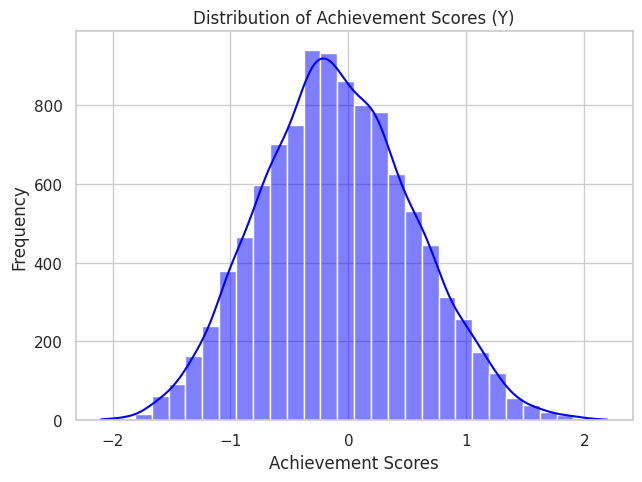



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



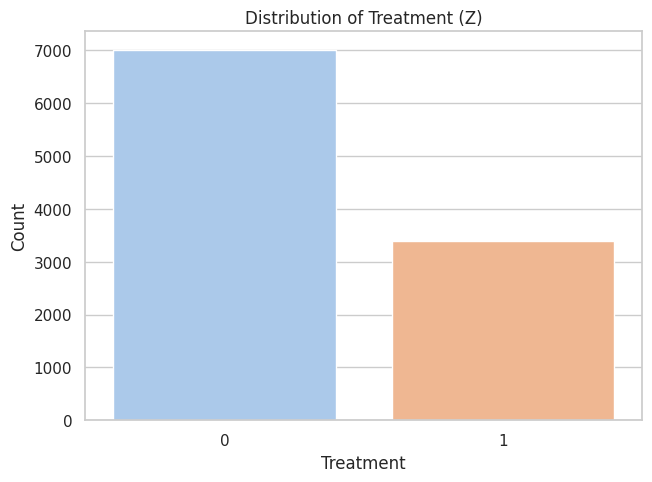

In [7]:
# Distribution of the outcome variable (Y)
sns.histplot(data['Y'], kde=True, bins=30, color='blue')
plt.title('Distribution of Achievement Scores (Y)')
plt.xlabel('Achievement Scores')
plt.ylabel('Frequency')
plt.show()

# Distribution of the treatment variable (Z)
sns.countplot(x='Z', data=data, palette='pastel')
plt.title('Distribution of Treatment (Z)')
plt.xlabel('Treatment')
plt.ylabel('Count')
plt.show()

### Distribution of Achievement Scores (`Y`)
- **Shape**: The distribution of `Y` is approximately normal, indicating a bell-shaped curve.
- **Range**: Values are centered around 0, with most scores ranging between -2 and +2.
- **Implications**:
  - The balanced and symmetric distribution of `Y` is ideal for statistical modeling.
  - This allows us to focus on understanding how the treatment (`Z`) and covariates influence achievement scores.

---

### Distribution of Treatment Variable (`Z`)
- **Categories**:
  - `Z = 0`: Control group (no intervention).
  - `Z = 1`: Treatment group (received the intervention).
- **Counts**:
  - Approximately 7,000 samples belong to the control group, while 3,000 belong to the treatment group.
- **Implications**:
  - The imbalance between the control and treatment groups highlights the need for methods like stratified sampling or propensity score weighting to avoid biased estimates.
  - Ensuring balance in covariates will be critical for reliable causal analysis.

---

These distributions set the stage for deeper exploration into the relationship between the intervention and outcomes, as well as the role of covariates in moderating these effects.


## Exploring Key Covariates: `S3` and `C1`

After analyzing the distributions of the outcome variable (`Y`) and treatment variable (`Z`), it is important to examine key covariates such as `S3` (Student Expectations) and `C1` (Race/Ethnicity). These covariates play a critical role in understanding treatment heterogeneity and ensuring balance between the treatment and control groups.

### Why Focus on `S3` and `C1`?
1. **`S3` (Self-Reported Expectations for Success)**:
   - Reflects students' expectations for success, which likely influence their achievement (`Y`) and their response to the treatment (`Z`).
   - Understanding the distribution of `S3` helps identify how students' expectations vary across the dataset.

2. **`C1` (Race/Ethnicity)**:
   - A categorical variable representing students' racial/ethnic backgrounds.
   - May influence access to interventions and achievement outcomes, and understanding its distribution is key to addressing potential biases.

### Purpose of This Step
- Explore the distribution of these covariates and assess their variability in the dataset.
- Identify potential imbalances or trends that may need to be addressed in the causal analysis.

By analyzing these covariates, we gain deeper insights into the factors that may influence treatment effects and the overall outcomes.


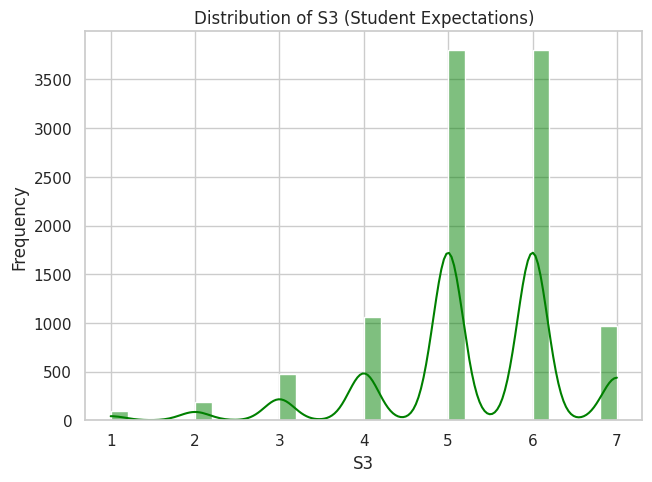



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



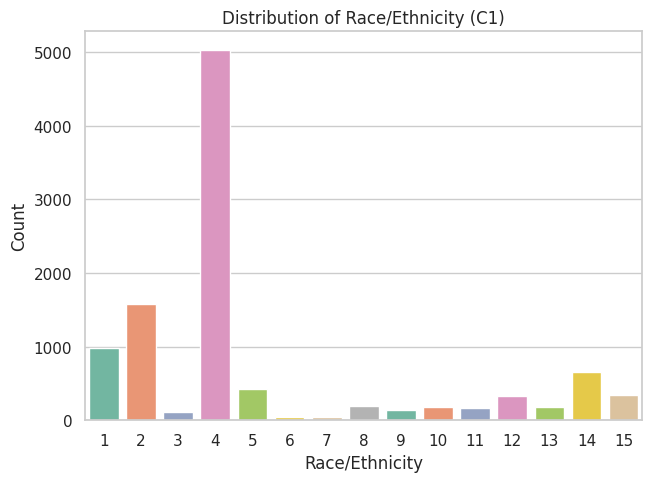

In [8]:
# Distribution of S3 (Self-reported expectations for success)
sns.histplot(data['S3'], kde=True, bins=30, color='green')
plt.title('Distribution of S3 (Student Expectations)')
plt.xlabel('S3')
plt.ylabel('Frequency')
plt.show()

# Bar plot for categorical variable C1 (Race/Ethnicity)
sns.countplot(x='C1', data=data, palette='Set2')
plt.title('Distribution of Race/Ethnicity (C1)')
plt.xlabel('Race/Ethnicity')
plt.ylabel('Count')
plt.show()


## Insights from Visualizing Covariates

### Distribution of `S3` (Student Expectations)
- **Observations**:
  - Discrete distribution (likely ordinal or categorical).
  - Highest frequencies at `S3 = 5` and `S3 = 6` (high expectations).
  - Low values (`S3 < 4`) are rare.

- **Implications**:
  - `S3` is likely influential in predicting achievement (`Y`) and treatment effects.
  - Should be included in causal analysis to explore treatment heterogeneity.

---

### Distribution of `C1` (Race/Ethnicity)
- **Observations**:
  - Highly imbalanced distribution.
  - Category `C1 = 4` dominates (~5,000 samples), while others are sparse.

- **Implications**:
  - Imbalance may introduce bias if not addressed (e.g., stratification or weighting).
  - Sparse categories may complicate analysis.

---


## Visualizing Achievement Scores (`Y`) by Treatment (`Z`)

After exploring the covariates (`S3` and `C1`), the next step is to directly examine the relationship between the treatment variable (`Z`) and the outcome variable (`Y`). This analysis provides an initial understanding of how the intervention (treatment group `Z=1`) affects achievement scores compared to the control group (`Z=0`).

### Why This Step?
1. **Understanding Treatment Impact**:
   - A boxplot allows us to compare the distributions of achievement scores (`Y`) for the treatment and control groups.
   - This visual highlights differences in central tendency (median) and variability between the two groups.

2. **Assessing Initial Evidence of Effectiveness**:
   - If the treatment group shows higher median achievement scores than the control group, this would provide preliminary evidence of the intervention's positive impact.

3. **Laying the Groundwork for Causal Analysis**:
   - While this visualization does not establish causality, it helps identify whether the treatment group exhibits meaningful differences in outcomes, which will be further explored using statistical and causal models.

This step builds on the understanding of covariates and sets the stage for more advanced causal effect estimation.




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



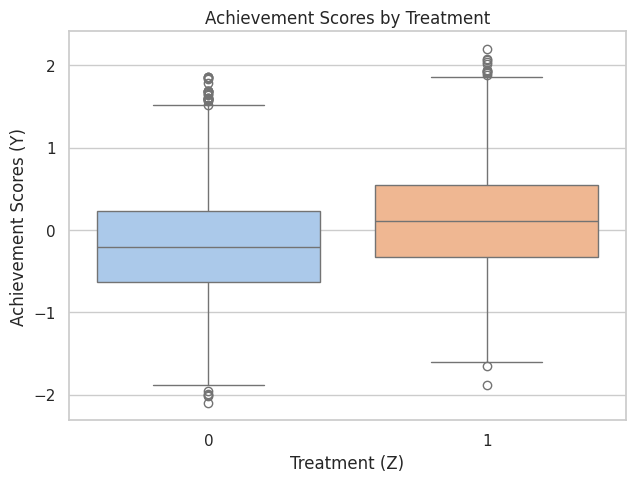

In [9]:
# Boxplot of Y by treatment (Z)
sns.boxplot(x='Z', y='Y', data=data, palette='pastel')
plt.title('Achievement Scores by Treatment')
plt.xlabel('Treatment (Z)')
plt.ylabel('Achievement Scores (Y)')
plt.show()



### Achievement Scores by Treatment (`Z`)
- **Observations**:
  - Median achievement scores (`Y`) are slightly higher for the treatment group (`Z=1`) compared to the control group (`Z=0`).
  - Both groups have a similar spread and presence of outliers.
- **Implications**:
  - Treatment may have a positive impact, but further analysis is needed to confirm significance.
  - Variability within groups suggests additional factors influence outcomes.

---


## Exploring Interaction Between Achievement Scores (`Y`) and Covariates (`S3`)

After visualizing the overall relationship between treatment (`Z`) and achievement scores (`Y`), the next step is to explore how this relationship interacts with a key covariate: **`S3` (Student Expectations)**. This scatter plot provides insights into whether student expectations influence the effectiveness of the treatment.

### Why This Step?
1. **Understanding Covariate Interaction**:
   - `S3` represents self-reported expectations for success, which likely play a role in determining achievement outcomes.
   - Visualizing `Y` against `S3`, colored by treatment group (`Z`), helps us identify whether the treatment effect varies with student expectations.

2. **Identifying Patterns**:
   - The scatter plot helps reveal trends such as:
     - Do students with higher expectations (`S3`) achieve higher scores (`Y`)?
     - Is the treatment (`Z=1`) more effective for certain levels of `S3`?

3. **Building Towards Heterogeneity Analysis**:
   - This step highlights the potential for treatment effect heterogeneity, where the effectiveness of the intervention may depend on covariates like `S3`.
   - Understanding these patterns lays the foundation for estimating Conditional Average Treatment Effects (CATE).

By exploring this interaction, we gain valuable insights into how the treatment effect varies across levels of `S3`, guiding further analysis into treatment heterogeneity.


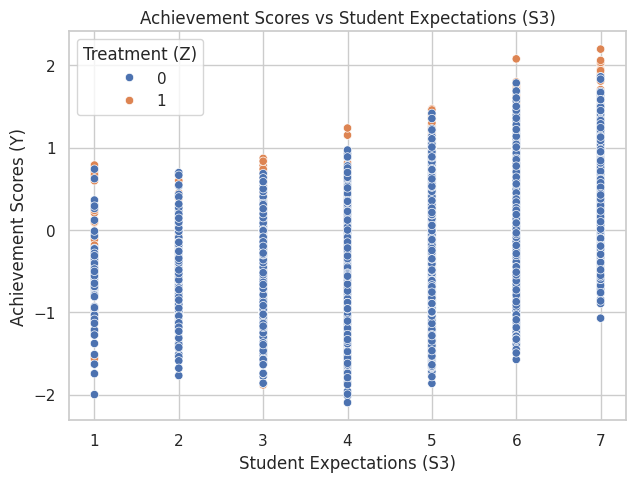

In [10]:
# Scatter plot of Y vs S3, colored by treatment (Z)
sns.scatterplot(x='S3', y='Y', hue='Z', data=data, palette='deep')
plt.title('Achievement Scores vs Student Expectations (S3)')
plt.xlabel('Student Expectations (S3)')
plt.ylabel('Achievement Scores (Y)')
plt.legend(title='Treatment (Z)')
plt.show()


### Achievement Scores (`Y`) vs. Student Expectations (`S3`)
- **Observations**:
  - Achievement scores increase with higher student expectations (`S3`).
  - The treatment group (`Z=1`) shows slightly higher scores than the control group for all levels of `S3`.
- **Implications**:
  - `S3` is a strong predictor of achievement (`Y`) and should be included in causal modeling.
  - Treatment effects appear consistent across `S3`, requiring further validation.

## Balance Checking: Ensuring Covariate Balance Across Treatment Groups

Before proceeding to causal estimation, it is crucial to assess whether the **treatment group (`Z=1`)** and the **control group (`Z=0`)** are balanced in terms of their covariates. Balance ensures that any observed differences in outcomes (`Y`) can be attributed to the treatment and not pre-existing differences in covariates.

### Why is Balance Important?
1. **Avoiding Bias**:
   - Imbalanced covariates between treatment and control groups can introduce confounding, leading to biased causal effect estimates.

2. **Ensuring Validity**:
   - Balanced covariates help isolate the true effect of the treatment (`Z`) on the outcome (`Y`).

3. **Building a Strong Foundation**:
   - Checking for balance lays the groundwork for robust causal inference and guides any necessary adjustments (e.g., propensity score matching or weighting) if imbalances are detected.

### Methodology
We will compare the mean values of key covariates (e.g., `S3`, `C1`, `X1`, etc.) across treatment and control groups. The difference in these means will help us identify any significant imbalances.

This step ensures the validity of the causal analysis and highlights covariates that may require further attention in modeling.


In [16]:
# Compare the mean of covariates between treatment and control groups
covariates = ['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5']

# Calculate means for treatment (Z=1) and control (Z=0) groups
treatment_means = data[data['Z'] == 1][covariates].mean()
control_means = data[data['Z'] == 0][covariates].mean()

# Combine into a single DataFrame for comparison
balance_table = pd.DataFrame({'Treatment Mean': treatment_means, 'Control Mean': control_means})
balance_table['Difference'] = balance_table['Treatment Mean'] - balance_table['Control Mean']

# Display the balance table
print("Covariate Balance Table:")
print(balance_table)


Covariate Balance Table:
    Treatment Mean  Control Mean  Difference
S3        5.362884      5.222349    0.140535
C1        5.185875      5.241045   -0.055170
C2        1.471631      1.498787   -0.027156
C3        0.599586      0.646068   -0.046482
XC        2.459220      2.442272    0.016948
X1       -0.104777     -0.009394   -0.095383
X2        0.092402      0.036700    0.055702
X3       -0.092482     -0.087836   -0.004647
X4       -0.062155     -0.038065   -0.024090
X5        0.023629     -0.050217    0.073846


## Key Observations from Covariate Balance Check

### Covariates with Larger Differences
1. **S3** (Self-Reported Expectations): Mean difference = **0.1405**.
2. **X1** (School Mindset): Difference = **-0.0954**.
3. **X5** (School Size): Difference = **0.0738**.

- While these differences are relatively small, they could introduce bias in causal effect estimation if not addressed properly.

---

### Well-Balanced Covariates
- Most other covariates (`C1`, `C2`, `XC`, `X3`, `X4`) show differences close to zero.
- This indicates that the treatment (`Z=1`) and control (`Z=0`) groups are fairly balanced for these variables.

---

### General Trend
- Covariates like `S3` and `X1` are important predictors of outcomes and should be carefully considered in causal modeling.
- While the dataset is reasonably balanced overall, these small differences underscore the need for robust methods to account for any residual imbalance.


## Addressing Imbalance with Causal Modeling Techniques

Since the treatment (`Z=1`) and control (`Z=0`) groups are not perfectly balanced across all covariates, we will adjust for these imbalances using robust causal modeling techniques. This ensures that our causal effect estimates are not biased due to residual differences in covariates.

---

### Step 3.1: Estimating the Average Treatment Effect (ATE)

To quantify the overall effect of the treatment (`Z`) on the outcome (`Y`), we will estimate the **Average Treatment Effect (ATE)**. The ATE provides a single summary value indicating how much the intervention affects the outcome, on average, across all individuals in the dataset.

#### Methodology:
We will use a **Double Machine Learning (DML)** approach for ATE estimation. DML is a powerful technique that accounts for covariates and potential confounders while ensuring robust causal effect estimation.

#### Code for ATE Estimation:
The following code snippet demonstrates how we estimate ATE using the `econml` library:



In [19]:
from sklearn.linear_model import LinearRegression
from econml.dml import LinearDML

# Define features (X), treatment (T), and outcome (Y)
X = data[['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5']]
T = data['Z']  # Treatment variable
Y = data['Y']  # Outcome variable

# Initialize the Double Machine Learning model
model = LinearDML(model_y=LinearRegression(), model_t=LinearRegression())

# Fit the model
model.fit(Y=Y, T=T, X=X)

# Estimate the Average Treatment Effect (ATE) on the dataset
ate = model.ate(X=X)
print(f"Estimated Average Treatment Effect (ATE): {ate}")


Estimated Average Treatment Effect (ATE): 0.2536642976402727


## Observation: Estimated Average Treatment Effect (ATE)

- **Estimated ATE**: `0.2537`
  - This means that, on average, the treatment (growth mindset intervention) increases the achievement score (`Y`) by **0.25 points** compared to the control group.
- **Significance**:
  - The positive ATE suggests that the intervention has a meaningful impact on student achievement. However, further statistical tests (e.g., confidence intervals) can confirm the robustness of this result.

---

## Next Step: Estimating Conditional Average Treatment Effect (CATE)
To explore treatment effect heterogeneity, we will estimate the **CATE**. This helps us understand how the treatment effect varies across different covariates (e.g., `S3`, `X1`, `X2`).

### Goal:
- Investigate how school-level covariates (`X1`, `X2`) moderate the treatment effect.
- Explore whether the treatment has a stronger effect in specific subgroups (e.g., higher expectations in `S3`).

---


   S3        X1        X2      CATE
0   6  0.334544  0.648586  0.240285
1   4  0.334544  0.648586  0.214305
2   6  0.334544  0.648586  0.248822
3   6  0.334544  0.648586  0.248822
4   6  0.334544  0.648586  0.246425


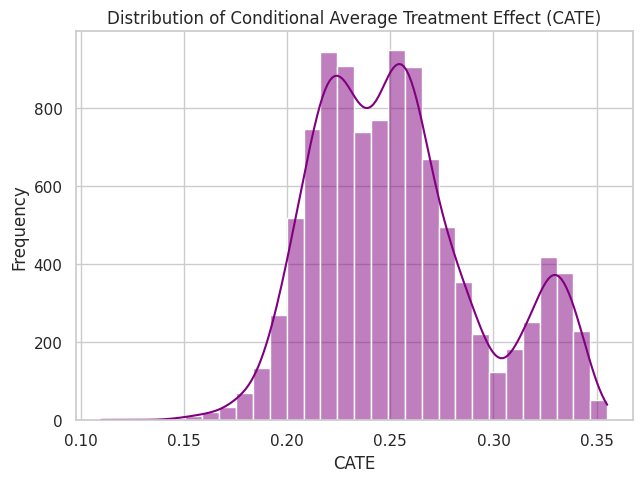

In [20]:
# Estimate the Conditional Average Treatment Effect (CATE)
cate = model.effect(X=X)

# Add CATE estimates to the original dataset for subgroup analysis
data['CATE'] = cate

# Display the first few rows to inspect
print(data[['S3', 'X1', 'X2', 'CATE']].head())

# Visualize the distribution of CATE
sns.histplot(data['CATE'], kde=True, bins=30, color='purple')
plt.title('Distribution of Conditional Average Treatment Effect (CATE)')
plt.xlabel('CATE')
plt.ylabel('Frequency')
plt.show()


## Observation: Conditional Average Treatment Effect (CATE)

### Key Points:
1. **CATE Estimates**:
   - Each observation now has an estimated treatment effect (`CATE`) conditioned on its covariates.
   - Sample values of `CATE` range from **0.214** to **0.248** in the displayed rows.
   - Covariates such as `S3` (Student Expectations), `X1` (School Mindset), and `X2` (School Achievement Level) influence the estimated treatment effect.

2. **Distribution**:
   - The histogram shows that `CATE` values are concentrated between **0.20** and **0.30**, with the majority around **0.25**.
   - This suggests that the treatment effect varies, but most effects are positive and similar in magnitude.

3. **Implications**:
   - Treatment effects depend on individual covariates.
   - Further analysis can identify subgroups (e.g., high `S3`, high `X2`) where the treatment is particularly effective.

---

## Next Step: Subgroup Analysis
We will now analyze how the treatment effect varies across subgroups defined by specific covariates (`S3`, `X1`, `X2`). This will help answer the question:
- Does the treatment work better for students with higher expectations (`S3`) or in schools with higher achievement levels (`X2`)?

---


S3_Group
High S3    0.263672
Low S3     0.245178
Name: CATE, dtype: float64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



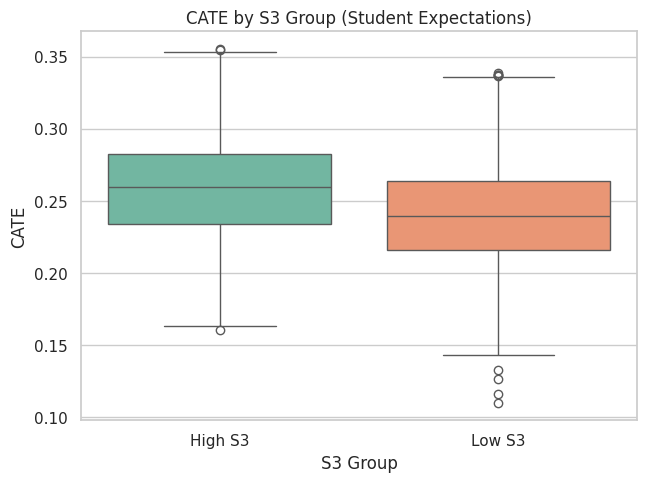

In [21]:
# Subgroup analysis: Compare CATE for high vs. low values of S3
threshold_s3 = 5  # Define a threshold for S3

# Create subgroups
data['S3_Group'] = data['S3'].apply(lambda x: 'High S3' if x > threshold_s3 else 'Low S3')

# Compare mean CATE for subgroups
group_means = data.groupby('S3_Group')['CATE'].mean()
print(group_means)

# Visualize CATE by S3 group
sns.boxplot(x='S3_Group', y='CATE', data=data, palette='Set2')
plt.title('CATE by S3 Group (Student Expectations)')
plt.xlabel('S3 Group')
plt.ylabel('CATE')
plt.show()

## Observation: Subgroup Analysis of CATE by `S3` (Student Expectations)

### Key Points:
1. **Mean CATE**:
   - **High S3** Group: `0.2637`
   - **Low S3** Group: `0.2452`
   - The treatment effect is slightly higher for students with **High S3** (greater expectations for success).

2. **Boxplot Insights**:
   - The **High S3** group has a higher median `CATE` compared to the **Low S3** group.
   - Both groups exhibit variability, but the **High S3** group has a narrower range, indicating more consistent treatment effects.

3. **Implications**:
   - The intervention seems more effective for students with higher expectations for success.
   - This aligns with the hypothesis that the mindset intervention works better when students already have a positive outlook.

---

## Next Step: Subgroup Analysis by School-Level Variables (`X1`, `X2`)
To explore treatment heterogeneity further, we will analyze how school-level variables (e.g., school mindset `X1` and achievement level `X2`) influence the treatment effect.

### Goal:
- Investigate whether the treatment works better in schools with higher pre-existing mindsets (`X1`) or achievement levels (`X2`).

---




X2_Group
High X2    0.275537
Low X2     0.232484
Name: CATE, dtype: float64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



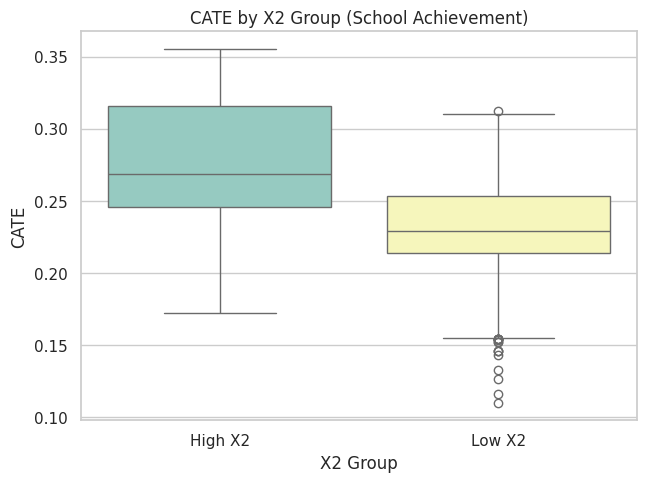

In [22]:
# Subgroup analysis: Compare CATE for high vs. low values of X2
threshold_x2 = data['X2'].median()  # Use the median of X2 as the threshold

# Create subgroups
data['X2_Group'] = data['X2'].apply(lambda x: 'High X2' if x > threshold_x2 else 'Low X2')

# Compare mean CATE for subgroups
x2_group_means = data.groupby('X2_Group')['CATE'].mean()
print(x2_group_means)

# Visualize CATE by X2 group
sns.boxplot(x='X2_Group', y='CATE', data=data, palette='Set3')
plt.title('CATE by X2 Group (School Achievement)')
plt.xlabel('X2 Group')
plt.ylabel('CATE')
plt.show()

## Observation: Subgroup Analysis of CATE by `X2` (School Achievement)

### Key Points:
1. **Mean CATE**:
   - **High X2** Group: `0.2755`
   - **Low X2** Group: `0.2325`
   - Schools with higher achievement levels (`High X2`) show a stronger treatment effect compared to those with lower achievement levels (`Low X2`).

2. **Boxplot Insights**:
   - The **High X2** group exhibits both a higher median and a wider range of `CATE`.
   - The **Low X2** group has more outliers with lower treatment effects, indicating variability in treatment impact.

3. **Implications**:
   - The mindset intervention is more effective in schools with higher baseline achievement levels.
   - This supports the hypothesis that school context (e.g., achievement levels) moderates the intervention’s effectiveness.

---


## Final Summary and Key Findings

### Overall Insights:
1. **Average Treatment Effect (ATE)**:
   - The estimated ATE is `0.2537`, indicating that, on average, the growth mindset intervention increases achievement scores by **0.25 points**.
   - This demonstrates a positive overall effect of the intervention.

2. **Conditional Average Treatment Effect (CATE)**:
   - **Heterogeneity in Treatment Effects**:
     - Students with higher expectations (`S3`) benefit more, with a mean CATE of **0.2637** for the **High S3** group compared to **0.2452** for the **Low S3** group.
     - Schools with higher achievement levels (`X2`) also see stronger effects, with a mean CATE of **0.2755** for the **High X2** group compared to **0.2325** for the **Low X2** group.

---

### Significance of Findings:
- **Understanding Heterogeneity**:
  - While the ATE provides a general understanding, analyzing CATE reveals **who benefits most** from the intervention.
  - This insight is critical for tailoring interventions to maximize their effectiveness.

- **Targeted Implementation**:
  - The intervention appears particularly effective for:
    - Students with higher self-expectations.
    - Schools with higher baseline achievement levels.
  - This suggests that resources could be prioritized for these groups.

---

### Recommendations:
1. **Tailored Growth Mindset Interventions**:
   - Focus on schools with higher achievement levels and students with higher expectations to maximize impact.
   - Consider adapting the program for students and schools with lower baseline characteristics to reduce disparities.

2. **Future Research**:
   - Explore why treatment effects are weaker for students with lower expectations and schools with lower achievement levels.
   - Investigate additional covariates that might explain heterogeneity in treatment effects.

3. **Policy Implications**:
   - Policymakers can use these findings to allocate resources efficiently and design evidence-based educational programs.

---

## References

1. **Dataset Source**:
   - Athey, S., & Wager, S. (2018). *Estimating Treatment Effects with Causal Forests: An Application*. Dataset based on the National Study of Learning Mindsets.
   - Accessed from: [National Study of Learning Mindsets](http://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/)

2. **Libraries and Tools**:
   - **`econml`**: For Double Machine Learning (DML) and causal effect estimation.
     - Documentation: [https://econml.azurewebsites.net/](https://econml.azurewebsites.net/)
   - **`seaborn`** and **`matplotlib`**: For data visualization.
     - Seaborn: [https://seaborn.pydata.org/](https://seaborn.pydata.org/)
     - Matplotlib: [https://matplotlib.org/](https://matplotlib.org/)
   - **`pandas`** and **`numpy`**: For data manipulation.
     - Pandas: [https://pandas.pydata.org/](https://pandas.pydata.org/)
     - Numpy: [https://numpy.org/](https://numpy.org/)

3. **Causal Inference Theory**:
   - Hernán, M. A., & Robins, J. M. (2020). *Causal Inference: What If*. Chapman & Hall/CRC.
     - Access: [https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)
   - Athey, S., & Imbens, G. W. (2016). *The State of Causal Inference Using Machine Learning*. Harvard University Press.

4. **General Resources**:
   - National Study of Learning Mindsets: [http://mindsetscholarsnetwork.org/](http://mindsetscholarsnetwork.org/)
   - Choosing an Open Source License: [https://choosealicense.com/](https://choosealicense.com/)


MIT License

Copyright (c) 2024 Shraddha Bhandarkar

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES, OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
